In [16]:
import cobra
import re
from urllib import request 
from pprint import pprint
import pandas as pd
import memote
import numpy as np
import copy
import os 
import sklearn 
import matplotlib.pyplot as plt


# Human1 Memote evaluation

In [3]:

! memote report snapshot --filename "Human1.html" Human-GEM.xml 

The current solver interface glpk doesn't support setting the optimality tolerance.
============================= test session starts ==============================
platform darwin -- Python 3.10.8, pytest-7.1.2, pluggy-1.0.0
rootdir: /Users/benjaminreyes
plugins: anyio-3.5.0, typeguard-4.4.2
collected 191 items / 1 skipped                                                

../../../../../../anaconda3/lib/python3.10/site-packages/memote/suite/tests/test_annotation.py . [  0%]
..FFFFFFFFFFFFFFFFFFFFF.FFFFFFFF.FFF.FFFF.F..FF.FFFFF.FFF.FFFF..         [ 34%]
../../../../../../anaconda3/lib/python3.10/site-packages/memote/suite/tests/test_basic.py . [ 34%]
...F.FF.......F.F.F.FF                                                   [ 46%]
../../../../../../anaconda3/lib/python3.10/site-packages/memote/suite/tests/test_biomass.py . [ 46%]
FFFFFFFFFFF.FFFFF.............FFFFFFFFFFF.......FFFFFF                   [ 74%]
../../../../../../anaconda3/lib/python3.10/site-packages/memote/suite/tests/test_

In [2]:

os.chdir('/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/neutrophil-modeling/curation/Human1_coverage')
print(os.getcwd())



/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/neutrophil-modeling/curation/Human1_coverage



# Use the data set from the repository  
### https://raw.githubusercontent.com/SysBioChalmers/Human-GEM/main/model/genes.tsv
### https://raw.githubusercontent.com/SysBioChalmers/Human-GEM/main/model/reactions.tsv
### https://raw.githubusercontent.com/SysBioChalmers/Human-GEM/main/model/metabolites.tsv



#  Get Human1 ids for: Genes, Reactions, Metabolites  

In [3]:
def get_model_ids_for_databases(model, component_type, databases):
    """
    Extract ids from model annotations for various databases across a specified component type.
    
    Parameters:
    - model: COBRApy model object (mitocore)
    - component_type: str, one of 'reactions', 'metabolites', 'genes'
    - databases: list of str, e.g., ['kegg', 'bigg', 'metanetx', 'uniprot'].
    
    Returns:
    - DataFrame with component ID and extracted database ids.
    """
    # Initialize dictionary
    ids_dict = {'model_id': []}
    for db in databases: 
        ids_dict[db] = []

    # Access model component (e.g., reactions, genes)
    components = getattr(model, component_type)

    for comp in components:
        ids_dict['model_id'].append(comp.id)

        for db in databases:
            value = None
            annotation = comp.annotation

            # Try several naming conventions
            for key in [db, 
                        f"{db}.reaction", 
                        f"{db}.compound", 
                        f"{db}.metabolite", 
                        f"{db}.chemical", 
                        f"{db}.genes"]:
                if key in annotation:
                    value = annotation[key]
                    break

            ids_dict[db].append(value)

    return pd.DataFrame(ids_dict)


def map_ids_to_human_gem(ids_df, databases, mapping_file):
    """
    Map IDs from a model to HUMAN-GEM IDs using a mapping file.

    Parameters:
    - ids_df: DataFrame with model IDs and external database IDs.
    - databases: List of database names to try matching (e.g., ['kegg', 'bigg']).
    - mapping_file: Path to TSV file with mappings to HUMAN-GEM.

    Returns:
    - DataFrame with model_id and corresponding Human1_id.
    """

    mapping_df = pd.read_csv(mapping_file, sep='\t')
    ids_dict = {'model_id': [], 'Human1.compound': []}

    for index, row in ids_df.iterrows():  # <--- Define row here
        human1_id = None

        for db in databases:  # <--- Now row is accessible
            db_values = row[db]

            # Safe handling of possible list or scalar values
            if isinstance(db_values, (list, tuple)):
                values_list = db_values
            elif pd.isna(db_values) or str(db_values).lower() == 'nan':
                continue
            else:
                values_list = [str(db_values)]

            # Find relevant column in mapping file
            col_match = next((col for col in mapping_df.columns if db.lower() in col.lower()), None)
            if not col_match:
                continue

            # Try to match any value in the list
            for val in values_list:
                match = mapping_df[mapping_df[col_match].astype(str).str.contains(str(val), na=False, case=False)]
                if not match.empty:
                    human1_id = match.iloc[0, 0]  # Get value by column index
                    break
            if human1_id:
                break  # Stop searching other DBs if match is found

        ids_dict['model_id'].append(row['model_id'])
        ids_dict['Human1.compound'].append(human1_id)

    return pd.DataFrame(ids_dict)


## Call functions to get ids and visualization and save as .csv file


In [ ]:



print('geting ids for all possible databases ')
df_react =get_model_ids_for_databases(mitocore, 'reactions', ['kegg', 'bigg', 'metanetx'])
df_metab = get_model_ids_for_databases(mitocore, 'metabolites', ['kegg', 'bigg', 'metanetx'])
df_genes = get_model_ids_for_databases(mitocore, 'genes', ['uniprot', 'kegg'])

print('reactions \n',df_react)
print('metabolites \n',df_metab)
print('genes \n', df_genes)

print('Mapping reactions, metabolites, and genes to Human1 ids.')
df_Human1_react = map_ids_to_human_gem(df_react, ['kegg', 'bigg', 'metanetx'], 'Human1_reactions.tsv')
df_Human1_metab = map_ids_to_human_gem(df_metab,['kegg', 'bigg', 'metanetx'], 'Human1_metabolites.tsv')
df_Human1_genes = map_ids_to_human_gem(df_genes,['uniprot', 'kegg'], 'Human1_genes.tsv')

print('Human1 reactions \n',df_Human1_react)
print('Human1 metabolites \n',df_Human1_metab)
print('Human1 genes \n', df_Human1_genes)

geting ids for all possible databases 
reactions 
        model_id  kegg        bigg    metanetx
0      EX_2hb_e  None        None        None
1       EX_ac_e  None        None        None
2     EX_acac_e  None        None        None
3      EX_akg_e  None        None        None
4    EX_ala_B_e  None        None        None
..          ...   ...         ...         ...
550         COt  None         COt  MNXR153251
551         NOt  None         NOt  MNXR191149
552  PCHOLHSTDe  None  PCHOLHSTDe  MNXR102406
553        PSt3  None        PSt3  MNXR192024
554         PEt  None         PEt  MNXR102505

[555 rows x 4 columns]
metabolites 
        model_id    kegg        bigg     metanetx
0      10fthf_c  C00234      10fthf  MNXM1102376
1      10fthf_m  C00234      10fthf  MNXM1102376
2       13dpg_c  C00236       13dpg  MNXM1108073
3    1pipdn2c_c  C04092    1pipdn2c      MNXM911
4      1pyr5c_m  C03912        None  MNXM1105060
..          ...     ...         ...          ...
436   myrsACP_c 

/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_22737/396601792.py:81: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  match = mapping_df[mapping_df[col_match].astype(str).str.contains(str(val), na=False, case=False)]
/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_22737/396601792.py:81: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  match = mapping_df[mapping_df[col_match].astype(str).str.contains(str(val), na=False, case=False)]
/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_22737/396601792.py:81: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  match = mapping_df[mapping_df[col_match].astype(str).str.contains(str(val), na=False, case=False)]
/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipy

Human1 reactions 
        model_id Human1.compound
0      EX_2hb_e            None
1       EX_ac_e            None
2     EX_acac_e            None
3      EX_akg_e            None
4    EX_ala_B_e            None
..          ...             ...
550         COt        MAR08261
551         NOt        MAR05009
552  PCHOLHSTDe        MAR07158
553        PSt3        MAR01669
554         PEt        MAR00651

[555 rows x 2 columns]
Human1 metabolites 
        model_id Human1.compound
0      10fthf_c       MAM00266c
1      10fthf_m       MAM00266c
2       13dpg_c       MAM00247c
3    1pipdn2c_c       MAM01663x
4      1pyr5c_m       MAM00559c
..          ...             ...
436   myrsACP_c       MAM02972c
437   HC01605_c       MAM00880c
438   HC01326_c       MAM00162c
439   HC01606_c       MAM00050c
440   palmACP_c       MAM02115c

[441 rows x 2 columns]
Human1 genes 
             model_id  Human1.compound
0    ENSG00000156515  ENSG00000156515
1    ENSG00000159399  ENSG00000159399
2    ENSG000001

# Approach counts for Human1 positives

In [32]:
def coverage_human1(model, component):

    """
    Classify Human1 ids for a specified component type in a model in Boolean dataframe

    Parameters:
    - model: COBRApy model object (e.g., mitocore)
    - component: str, one of 'reactions', 'metabolites', 'genes'
    
    Returns:
    - dataframe containing lists of positive and negative Human1 IDs.
    """
    human1_positive = []
    human1_negative = []

    for comp in getattr(model, component):
        annotations = comp.annotation  # Access the annotations of the component
        if 'Human1' in annotations and annotations['Human1']:
            human1_pos_id = comp.id  # Use the component's ID
            human1_positive.append(human1_pos_id)  # Append to the positive list
        else:
            human1_neg_id = comp.id  # Use the component's ID
            human1_negative.append(human1_neg_id)  # Append to the negative list

    print(f"{component} positive:", len(human1_positive))
    print(f"{component} negative:", len(human1_negative))
    print(f"total {component}:", len(human1_negative) + len(human1_positive))

    #returns dataframe with counts of true 
    human1_coverage = pd.DataFrame({
        'id': human1_positive + human1_negative,
        'has_Human1': [True]*len(human1_positive) + [False]*len(human1_negative)
    })
    return human1_coverage


def counts_human1 (coverage_df, component):
    """ Count Human1 positive from boolean dataframe

    Parameters:
    - coverage_df: Boolean dataframe (True if Human1 id present, False if missing)
    - component: str, one of 'reactions', 'metabolites', 'genes'
    
    Returns:
    - dataframe with counts total components and positive components for pie chart plot.       

    """
    total= len(coverage_df['id']) # total number of components 
    counter_positive= 0 

    for rnx, row in coverage_df.iterrows(): #iterate over rows
        if row['has_Human1']: #check if 'has_Human1' is True in Boolean dataframe (True or False)
            counter_positive += 1 

    #returns dataframe with total counts and positive counts
    return pd.DataFrame({
        f"total {component}:" : [total],
        'Human1 positive': [counter_positive]
                         })

def coverage_piechart(counts_df,component):
    """
    Generate a pie chart based on the counts of Human1 positives and total components.

    Parameters:
    - counts_df: DataFrame with columns for total components and Human1 positives.

    Returns:
    - Displays a pie chart.
    """
    for _, row in counts_df.iterrows():
        # Extract values for the pie chart
        total = row.iloc[0]  # First column: total components
        positive = row.iloc[1]  # Second column: Human1 positives
        negative = total - positive  # Calculate negatives

        values = [positive, negative]
        labels = ['Human1 Positive', 'Human1 Negative']
        colors = ['green', 'white']

        # Create the pie chart
        plt.figure(figsize=(8, 6))
        fig, ax = plt.subplots()
        ax.pie(values, labels=labels, autopct='%1.1f%%', colors= colors, startangle=90)
       
        plt.title(f"Coverage of {component} Human1 ids")
        ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

        plt.grid(True)

        return plt.show()




metabolites positive: 421
metabolites negative: 20
total metabolites: 441
              id  has_Human1
0       10fthf_c        True
1       10fthf_m        True
2        13dpg_c        True
3     1pipdn2c_c        True
4       1pyr5c_m        True
..           ...         ...
436        PMF_m       False
437     hcys_L_c       False
438  L2aadp6sa_c       False
439  L2aadp6sa_m       False
440       lpro_m       False

[441 rows x 2 columns]
   total metabolites:  Human1 positive
0                 441              421


<Figure size 800x600 with 0 Axes>

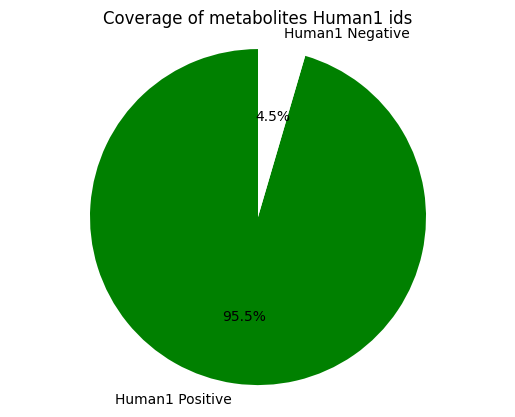

reactions positive: 395
reactions negative: 160
total reactions: 555
              id  has_Human1
0       10fthf_c        True
1       10fthf_m        True
2        13dpg_c        True
3     1pipdn2c_c        True
4       1pyr5c_m        True
..           ...         ...
436        PMF_m       False
437     hcys_L_c       False
438  L2aadp6sa_c       False
439  L2aadp6sa_m       False
440       lpro_m       False

[441 rows x 2 columns]
   total reactions:  Human1 positive
0               555              395


<Figure size 800x600 with 0 Axes>

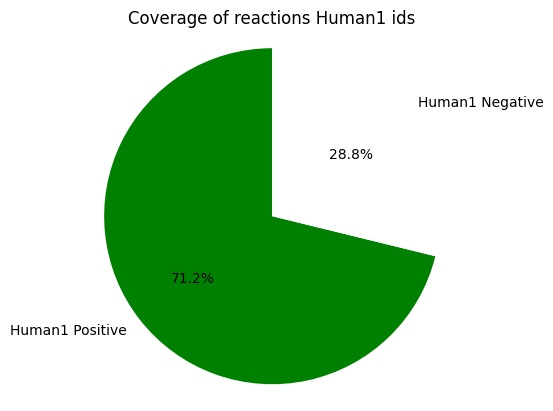

genes positive: 595
genes negative: 0
total genes: 595
                  id  has_Human1
0    ENSG00000156515        True
1    ENSG00000159399        True
2    ENSG00000160883        True
3    ENSG00000106633        True
4    ENSG00000131482        True
..               ...         ...
590  ENSG00000141469        True
591  ENSG00000132874        True
592  ENSG00000138449        True
593  ENSG00000018280        True
594  ENSG00000110911        True

[595 rows x 2 columns]
   total reactions:  Human1 positive
0               595              595


<Figure size 800x600 with 0 Axes>

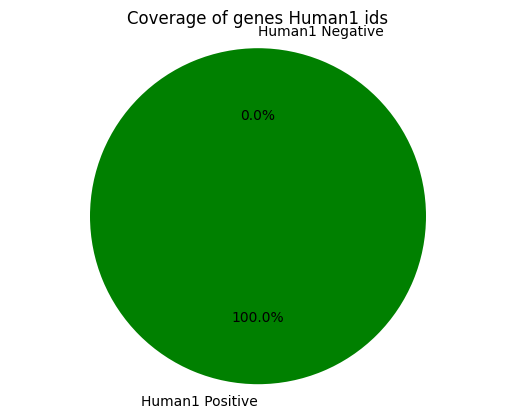

In [33]:
mitocore = cobra.io.read_sbml_model("Cleaned_Mitocore_changed_metabolites_metanetx.chemical.xml")

met= coverage_human1(mitocore, 'metabolites')
print(met)
met_c=counts_human1 (met,'metabolites')
print(met_c)
coverage_piechart(met_c, 'metabolites')


react= coverage_human1(mitocore, 'reactions')
print(met)
react_c = counts_human1(react, 'reactions')
print(react_c)
coverage_piechart(react_c,'reactions')

genes= coverage_human1(mitocore, 'genes')
print(genes)
genes_c = counts_human1(genes, 'reactions')
print(genes_c)
coverage_piechart(genes_c,'genes')


# """ Mitocore vs Human1  PCA """

# Set all reactions and metabolites 

In [6]:

mitocore = cobra.io.read_sbml_model("Mitocore_changed_reactions_Human1.xml")
human1 = cobra.io.read_sbml_model("Human-GEM.xml")

reactions1 = set([rxn for rxn in mitocore.reactions])
reactions2 = set([rxn for rxn in human1.reactions])

metabolites1 = set([met.id for met in mitocore.metabolites])
metabolites2 = set([met.id for met in human1.metabolites])

all_reactions = list(reactions1.union(reactions2))
all_metabolites = list(metabolites1.union(metabolites2))



# Sort metabolitesn into a unic list to take out repeats but keep all metabolites (BiGG and Human1)

In [ ]:
# Get a unique list of metabolite IDs (including Human1 mappings if available)
all_metabolites_sorted = []

for metabolite in all_metabolites:
    standard_id = metabolite
    annotation = getattr(metabolite, 'annotation', {})
    human1_id = annotation.get('Human1', None)
    #print(f"Processing metabolite: {standard_id}, Human1 ID: {human1_id}")

    all_metabolites_sorted.append(standard_id)
    if human1_id:
        all_metabolites_sorted.append(human1_id)

# Ensure unique and sorted
metabolite_ids = sorted(set(all_metabolites_sorted))
print('metabolite_ids', metabolite_ids)

count_Human1 = 0
count_mitocore= 0
# Check if each metabolite ID starts with 'MAM0' or not
for met in metabolite_ids:
    if met.startswith('MAM'):
        count_Human1 += 1
        
    else:
        count_mitocore += 1

print(f"Number of metabolites starting with 'MAM': {count_Human1}")
print(f"Number of metabolites not starting with 'MAM': {count_mitocore}") 

metabolite_ids ['10fthf_c', '10fthf_m', '13dpg_c', '1pipdn2c_c', '1pyr5c_m', '2aobut_m', '2hb_c', '2hb_e', '2maacoa_m', '2mb2coa_m', '2mbcoa_m', '2mop_m', '2mp2coa_m', '2obut_c', '2obut_m', '2oxoadp_c', '2oxoadp_m', '2pg_c', '34hpp_c', '3hanthrn_c', '3hbcoa_m', '3hexdcoa_m', '3hibutcoa_m', '3hmbcoa_m', '3hmp_m', '3mb2coa_m', '3mgcoa_m', '3mob_m', '3mop_m', '3odcoa_m', '3oddcoa_m', '3pg_c', '3php_c', '3sala_c', '3snpyr_c', '3tetd7ecoa_m', '4aabutn_m', '4abut_c', '4abut_m', '4abutn_c', '4fumacac_c', '4izp_c', '4mlacac_c', '4mop_m', '5aop_c', '5aop_m', '5forthf_c', '6a2ohxnt_c', '6pgc_c', '6pgl_c', 'ACP_c', 'HC00250_c', 'HC00250_e', 'HC01255_c', 'HC01321_c', 'HC01322_c', 'HC01323_c', 'HC01326_c', 'HC01335_c', 'HC01401_m', 'HC01403_m', 'HC01405_m', 'HC01406_m', 'HC01407_m', 'HC01408_m', 'HC01409_m', 'HC01410_m', 'HC01415_m', 'HC01587_c', 'HC01588_c', 'HC01589_c', 'HC01590_c', 'HC01591_c', 'HC01592_c', 'HC01593_c', 'HC01594_c', 'HC01595_c', 'HC01596_c', 'HC01597_c', 'HC01598_c', 'HC01599_c'

In [36]:
mitocore = cobra.io.read_sbml_model("Mitocore_changed_reactions_Human1.xml")
all_metabolites_mitocore = []

for metabolite in mitocore.metabolites:
    standard_id = metabolite.id
    annotation = getattr(metabolite, 'annotation', {})
    human1_id = annotation.get('Human1', None)
    #print(f"Processing metabolite: {standard_id}, Human1 ID: {human1_id}")

    all_metabolites_mitocore.append(standard_id)
    if human1_id:
        all_metabolites_mitocore.append(human1_id)

metabolite_ids = sorted(set(all_metabolites_mitocore))

print(len(all_metabolites_mitocore))
print(len(metabolite_ids), metabolite_ids)

862
702 ['10fthf_c', '10fthf_m', '13dpg_c', '1pipdn2c_c', '1pyr5c_m', '2aobut_m', '2hb_c', '2hb_e', '2maacoa_m', '2mb2coa_m', '2mbcoa_m', '2mop_m', '2mp2coa_m', '2obut_c', '2obut_m', '2oxoadp_c', '2oxoadp_m', '2pg_c', '34hpp_c', '3hanthrn_c', '3hbcoa_m', '3hexdcoa_m', '3hibutcoa_m', '3hmbcoa_m', '3hmp_m', '3mb2coa_m', '3mgcoa_m', '3mob_m', '3mop_m', '3odcoa_m', '3oddcoa_m', '3pg_c', '3php_c', '3sala_c', '3snpyr_c', '3tetd7ecoa_m', '4aabutn_m', '4abut_c', '4abut_m', '4abutn_c', '4fumacac_c', '4izp_c', '4mlacac_c', '4mop_m', '5aop_c', '5aop_m', '5forthf_c', '6a2ohxnt_c', '6pgc_c', '6pgl_c', 'ACP_c', 'HC00250_c', 'HC00250_e', 'HC01255_c', 'HC01321_c', 'HC01322_c', 'HC01323_c', 'HC01326_c', 'HC01335_c', 'HC01401_m', 'HC01403_m', 'HC01405_m', 'HC01406_m', 'HC01407_m', 'HC01408_m', 'HC01409_m', 'HC01410_m', 'HC01415_m', 'HC01587_c', 'HC01588_c', 'HC01589_c', 'HC01590_c', 'HC01591_c', 'HC01592_c', 'HC01593_c', 'HC01594_c', 'HC01595_c', 'HC01596_c', 'HC01597_c', 'HC01598_c', 'HC01599_c', 'HC01

# Plot PCA

Saved presence matrix to 'presence_matrix.csv'


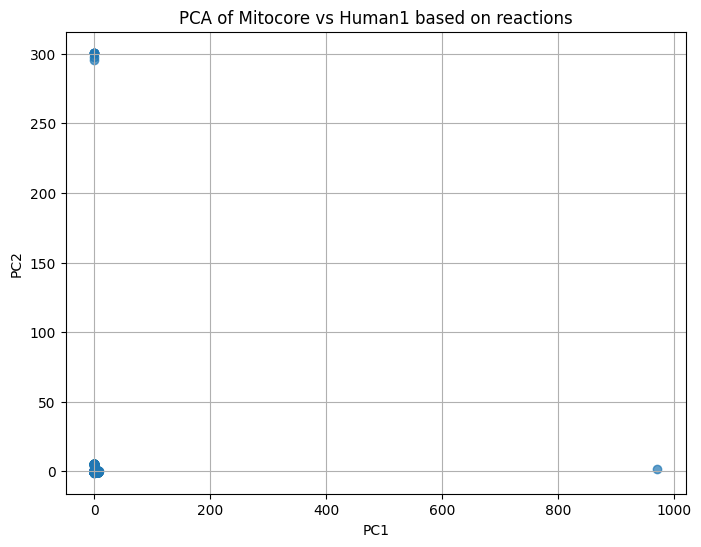

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Create an empty DataFrame with 0s
presence_matrix = pd.DataFrame(0, index=[rxn.id for rxn in all_reactions],
                               columns=metabolite_ids)

# Fill the matrix
for reaction in all_reactions:
    equation_str = reaction.reaction
    for met_id in metabolite_ids:
        if met_id in equation_str:
            presence_matrix.loc[reaction.id, met_id] = 1

# Save the matrix as CSV
print(presence_matrix.shape())
presence_matrix.to_csv('presence_matrix.csv')


# Standardize the matrix (important before PCA)
X_scaled = StandardScaler().fit_transform(presence_matrix)

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA result without reaction names
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Mitocore vs Human1 based on reactions')

plt.grid(True)
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=4)
labels = clustering.fit_predict(X_scaled)

# Add to PCA plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='rainbow')
plt.title('Clustering of Mitocore vs Human1 based on reactions')   
plt.show()

In [26]:
combined_index = all_reactions + all_metabolites + all_genes

data = {
    'Mitocore': [int(rxn in reactions1) for rxn in all_reactions] + 
                [int(met in metabolites1) for met in all_metabolites] + 
                [int(gene in genes1) for gene in all_genes],
    'Human1':   [int(rxn in reactions2) for rxn in all_reactions] + 
                [int(met in metabolites2) for met in all_metabolites] + 
                [int(gene in genes2) for gene in all_genes]
}

features= pd.DataFrame(data, index=combined_index).T
print(features.shape)



(2, 25328)


In [ ]:
%pip install scikit-learn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(reactions)

plt.scatter(components[:, 0], components[:, 1])
for i, name in enumerate(reactions.index):  # Iterate over the rows of the reactions DataFrame
    plt.text(components[i, 0], components[i, 1], name)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Mitocore vs Human1 based on reactions')
plt.show()

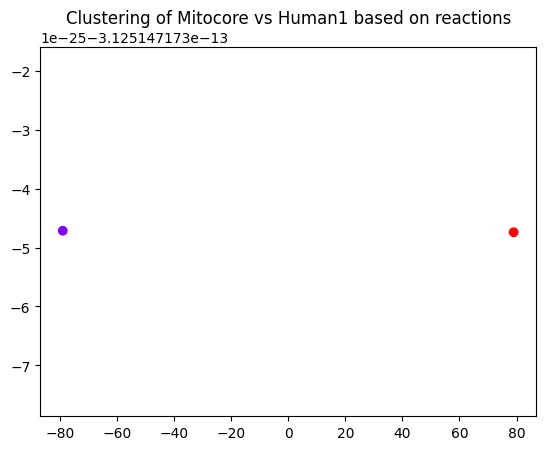

In [28]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=2)
labels = clustering.fit_predict(features)

# Add to PCA plot
plt.scatter(components[:, 0], components[:, 1], c=labels, cmap='rainbow')
plt.title('Clustering of Mitocore vs Human1 based on reactions')   
plt.show()

# -------------- EC codes quantification, absolute values ---------------

## ---- Emanuel's curation vs Benjamin's curation ----

In [4]:
os.chdir('/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/neutrophil-modeling/curation')
print(os.getcwd())

/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/neutrophil-modeling/curation


In [36]:
Curation_0= cobra.io.read_sbml_model('Mitocore_Curated_Emanuel.xml')
Curation_1=cobra.io.read_sbml_model('PMF_Metabolites_Correction.xml')

# ------- PCA for reactions and modules --------

In [ ]:

mitocore = cobra.io.read_sbml_model("/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/neutrophil-modeling/curation/Mitocore_GPR_Cleaned.xml")

#get human1 ids for reactions in mitocore
print('geting ids for all possible databases')
df_react =get_model_ids_for_databases(mitocore, 'reactions', ['Human1'])

# take just reactions with Human1 ids (if no Human1 id, then it can not be mapped for comparison)
react_with_human1 = df_react[df_react['Human1'].notnull()]
print('Reactions with Human1 IDs:')
print(react_with_human1)

# load the KEGG module data
modules_mito = pd.read_csv('kegg.module_mitocore.csv')
filtered = modules_mito[
    modules_mito['kegg.module'].notna() & 
    ~modules_mito['kegg.module'].isin(['', 'nan'])
]
print(filtered)

# merge fileterd modules with human1 ids dataframe based on mitocore model ids
human1_id_modules_mito= pd.merge(
    react_with_human1, 
    filtered,
    on='model_id',
    how='inner'
)
human1_id_modules_mito.to_csv('merged_modules_mito.csv', index=False) 





geting ids for all possible databases
Reactions with Human1 IDs:
       model_id    Human1
74         HEX1  MAR04394
76          PGI  MAR04381
77          PFK  MAR04379
78          FBP  MAR04377
79          FBA  MAR04375
..          ...       ...
550         COt  MAR08261
551         NOt  MAR05009
552  PCHOLHSTDe  MAR07158
553        PSt3  MAR01669
554         PEt  MAR08528

[395 rows x 2 columns]
               model_id kegg.module  \
0                  HEX1      M00001   
1                  HEX1      M00549   
7                   TPI      M00001   
8                   TPI      M00002   
9                   TPI      M00003   
..                  ...         ...   
518              CPPPGO      M00868   
524          PCHOLPm_hs      M00089   
525                GLYK      M00089   
526  GPAMm_hsB_MitoCore      M00093   
532       CLPN_MitoCore      M00052   

                                           module_name  
0    Glycolysis (Embden-Meyerhof pathway), glucose ...  
1               

In [100]:
modules_human1 = pd.read_csv('kegg.module_human1.csv')
filtered_human1 = modules_human1[
    modules_human1['kegg.module'].notna() & 
    ~modules_human1['kegg.module'].isin(['', 'nan'])
]
print(filtered_human1)

      model_id kegg.module                                        module_name
2     MAR04097      M00357                 Methanogenesis, acetate => methane
3     MAR04099      M00357                 Methanogenesis, acetate => methane
9     MAR04379      M00001  Glycolysis (Embden-Meyerhof pathway), glucose ...
10    MAR04379      M00345  Formaldehyde assimilation, ribulose monophosph...
12    MAR04355      M00165   Reductive pentose phosphate cycle (Calvin cycle)
...        ...         ...                                                ...
2169  MAR09572      M00632  Galactose degradation, Leloir pathway, galacto...
2172  MAR09806      M00538           Toluene degradation, toluene => benzoate
2178  MAR02141      M00012                                   Glyoxylate cycle
2180  MAR06328      M00032  Lysine degradation, lysine => saccharopine => ...
2183  MAR01169      M00036  Leucine degradation, leucine => acetoacetate +...

[942 rows x 3 columns]


# ------Create a list for binary matrix, where modules for Mitocore and Human1 are labeled---------

In [103]:
#Mitocore

modules_mito = pd.read_csv('merged_modules_mito.csv')

modules_mito['kegg.module'] = 'Mito_' + modules_mito['kegg.module'].astype(str)

# Save changes back to CSV
modules_mito.to_csv('merged_modules_mito_1.csv', index=False)

print(modules_mito)

               model_id    Human1  kegg.module  \
0                  HEX1  MAR04394  Mito_M00001   
1                  HEX1  MAR04394  Mito_M00549   
2                   TPI  MAR04391  Mito_M00001   
3                   TPI  MAR04391  Mito_M00002   
4                   TPI  MAR04391  Mito_M00003   
..                  ...       ...          ...   
398              CPPPGO  MAR04752  Mito_M00121   
399              CPPPGO  MAR04752  Mito_M00868   
400          PCHOLPm_hs  MAR00629  Mito_M00089   
401                GLYK  MAR00448  Mito_M00089   
402  GPAMm_hsB_MitoCore  MAR00579  Mito_M00093   

                                           module_name  
0    Glycolysis (Embden-Meyerhof pathway), glucose ...  
1                 UDP-Glc biosynthesis, Glc => UDP-Glc  
2    Glycolysis (Embden-Meyerhof pathway), glucose ...  
3    Glycolysis, core module involving three-carbon...  
4         Gluconeogenesis, oxaloacetate => fructose-6P  
..                                                 ...  


In [102]:
#Human1
modules_human1 = filtered_human1

modules_human1['kegg.module'] = 'Hum_' + modules_human1['kegg.module'].astype(str)
print(modules_human1)
# Save changes back to CSV
modules_human1.to_csv('modules_human1_1.csv', index=False)


      model_id kegg.module                                        module_name
2     MAR04097  Hum_M00357                 Methanogenesis, acetate => methane
3     MAR04099  Hum_M00357                 Methanogenesis, acetate => methane
9     MAR04379  Hum_M00001  Glycolysis (Embden-Meyerhof pathway), glucose ...
10    MAR04379  Hum_M00345  Formaldehyde assimilation, ribulose monophosph...
12    MAR04355  Hum_M00165   Reductive pentose phosphate cycle (Calvin cycle)
...        ...         ...                                                ...
2169  MAR09572  Hum_M00632  Galactose degradation, Leloir pathway, galacto...
2172  MAR09806  Hum_M00538           Toluene degradation, toluene => benzoate
2178  MAR02141  Hum_M00012                                   Glyoxylate cycle
2180  MAR06328  Hum_M00032  Lysine degradation, lysine => saccharopine => ...
2183  MAR01169  Hum_M00036  Leucine degradation, leucine => acetoacetate +...

[942 rows x 3 columns]


# Create list for binary matrix


In [90]:
modules= []
reactions_human1_ids=[]

for index, row in modules_human1.iterrows():
    modules.append(row['kegg.module'])
    reactions_human1_ids.append(row['model_id'])

for index, row in modules_mito.iterrows():
    modules.append(row['kegg.module'])
    reactions_human1_ids.append(row['Human1'])
    
print(len(modules))
print(len(reactions_human1_ids))

modules= list(set(modules))
reactions_human1_ids = list(set(reactions_human1_ids))

print(len(modules))
print(len(reactions_human1_ids))

1345
1345
315
703


# --------- Something is wrong with the loop to fill the matrix, Human1 modules are not being filled with 1 (all are 0) ------ 

### correct it !!!! PCA does not make sense like this

In [91]:
Matrix = pd.DataFrame(0, index=reactions_human1_ids, columns=modules)

# Fill the matrix
for reaction, module in zip(modules_human1['model_id'], modules_human1['kegg.module']):
    if module in modules:
        Matrix.loc[reaction, module] = 1

for reaction, module in zip(modules_mito['Human1'], modules_mito['kegg.module']):
    if module in modules:
        Matrix.loc[reaction, module] = 1

# Save the matrix as CSV
print(Matrix.shape)
Matrix.to_csv('presence_matrix.csv')

(703, 315)


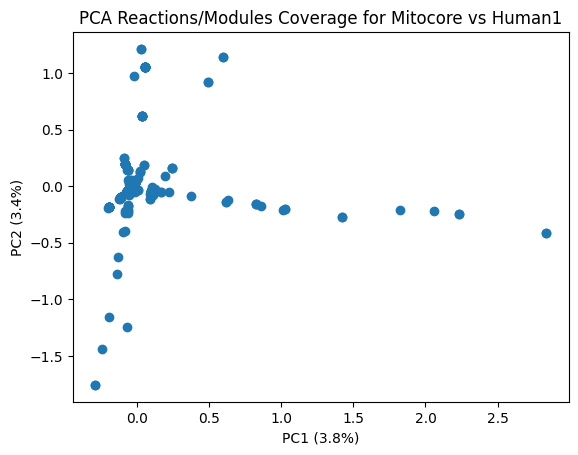

In [92]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Make sure the matrix contains only numeric values (0/1)
x = Matrix.values  # Convert DataFrame to numpy array

# 2. Create and fit PCA
pca = PCA(n_components=2)  # visualization in 2D
X_pca = pca.fit_transform(x)

# 3. Put PCA results into a DataFrame 
pca_df = pd.DataFrame(
    X_pca,
    index=Matrix.index,
    columns=['PC1', 'PC2']
)

# 4. Plot the PCA
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA Reactions/Modules Coverage for Mitocore vs Human1")
plt.show()

# -----Labeling the PCA with reactions comming from Mitocore, Human1 or both --------

In [ ]:
#Create color labels for reactions based on module presence

# Get module columns starting with 'Mito_' or 'Hum_'
mito_cols = [col for col in Matrix.columns if col.startswith('Mito_')]
hum_cols = [col for col in Matrix.columns if col.startswith('Hum_')]
print(len(mito_cols))
print(len(hum_cols))

# Sum presence of modules per reaction for each group
mito_sum = Matrix[mito_cols].sum(axis=1)
hum_sum = Matrix[hum_cols].sum(axis=1)

# Define reaction labels
def label_reaction(row):
    if row['mito'] > 0 and row['hum'] == 0:
        return 'Mito'
    elif row['hum'] > 0 and row['mito'] == 0:
        return 'Hum'
    elif row['mito'] > 0 and row['hum'] > 0:
        return 'Both'   
    else:
        return 'None'  # no module assigned?

labels_df = pd.DataFrame({'mito': mito_sum, 'hum': hum_sum})
model_labels = labels_df.apply(label_reaction, axis=1)

103
212


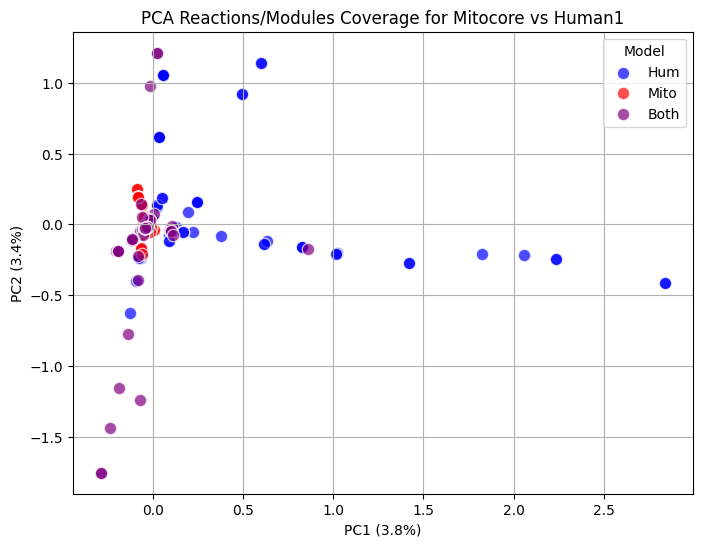

In [94]:
colors = {'Mito': 'red', 'Hum': 'blue', 'Both': 'purple', 'None': 'gray'}

plt.figure(figsize=(8,6))
for label in model_labels.unique():
    idx = model_labels == label
    plt.scatter(
        pca_df.loc[idx, 'PC1'],
        pca_df.loc[idx, 'PC2'],
        label=label,
        c=colors[label],
        alpha=0.7,
        edgecolors='w',
        s=80
    )
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA Reactions/Modules Coverage for Mitocore vs Human1")
plt.legend(title='Model')
plt.grid(True)
plt.show()